# Eye Diseases Classification

## Importing the Necessary Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

## Load the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# local copy of dataset, access from drive will be slow
!cp -r /content/drive/MyDrive/eye_dataset /content/dataset


In [5]:
folder_path = '/content/dataset'


glaucoma = Path(folder_path+'/glaucoma')
cataract = Path(folder_path+'/cataract')
normal = Path(folder_path+'/normal')
diabetic_retinopathy = Path(folder_path+'/diabetic_retinopathy')

In [6]:
from tqdm import tqdm

disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
#                   0         1      2            3
df = pd.DataFrame()
 # build the dataframe
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 2673.74it/s]


In [7]:
df

,image,disease_type
0,/content/dataset/glaucoma/_84_2885250.jpg,0
1,/content/dataset/glaucoma/Glaucoma_068.png,0
2,/content/dataset/glaucoma/_272_1072395.jpg,0
3,/content/dataset/glaucoma/_49_249201.jpg,0
4,/content/dataset/glaucoma/1478_left.jpg,0
...,...,...
4212,/content/dataset/diabetic_retinopathy/11584_le...,3
4213,/content/dataset/diabetic_retinopathy/1076_rig...,3
4214,/content/dataset/diabetic_retinopathy/11420_le...,3
4215,/content/dataset/diabetic_retinopathy/10794_le...,3


In [8]:
df.disease_type.value_counts()

,count
disease_type,
3,1098
2,1074
1,1038
0,1007


## Visualizing Images in Dataset

In [9]:
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

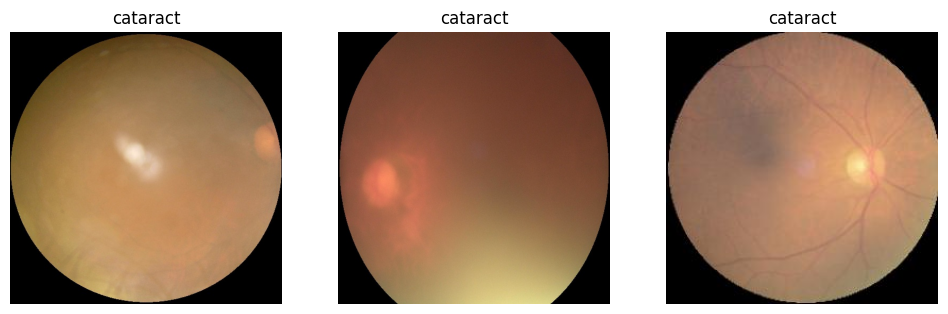

In [10]:
plot_image(1)

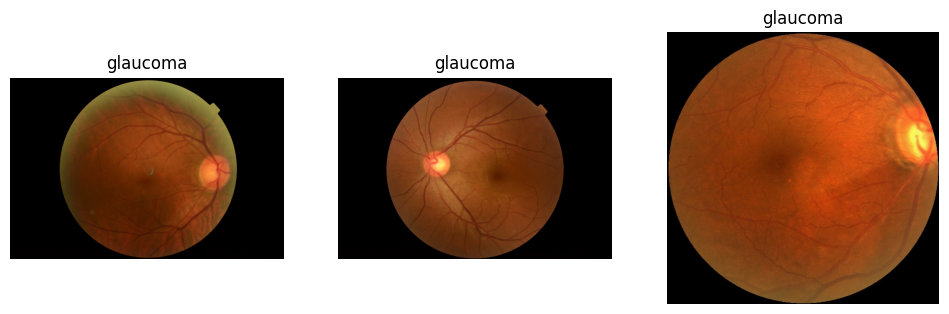

In [11]:
plot_image(0)

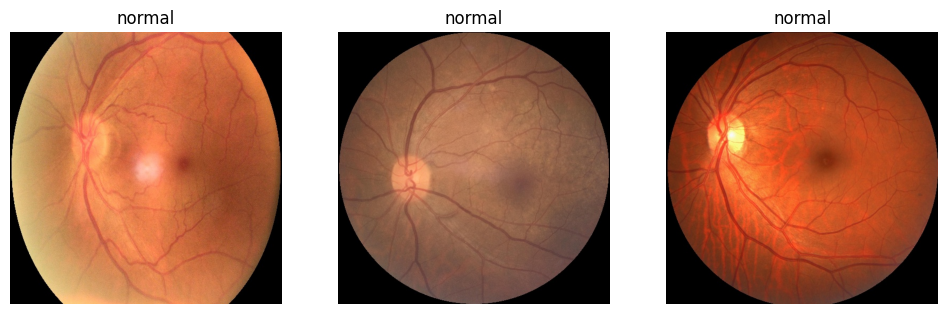

In [12]:
plot_image(2)

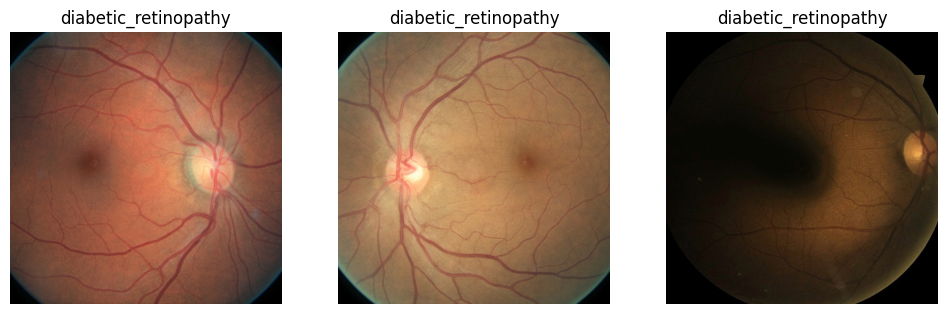

In [13]:
plot_image(3)

In [14]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [15]:
df.disease_type.value_counts()

,count
disease_type,
diabetic_retinopathy,1098
normal,1074
cataract,1038
glaucoma,1007


In [16]:
# shuffling the rows of a DataFrame df
df1=df.sample(frac=1).reset_index(drop=True)

/tmp/ipython-input-1364475135.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='disease_type', data=df1, palette=custom_palette)


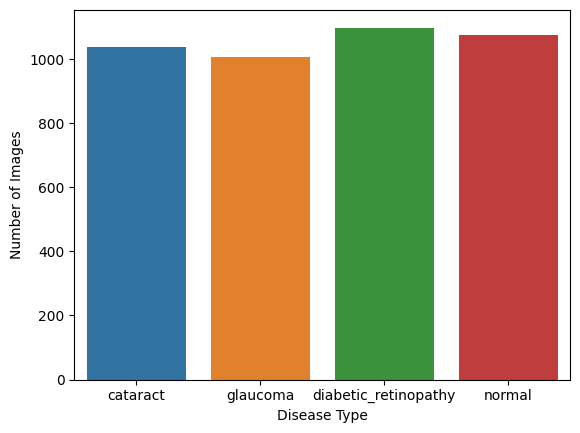

In [17]:
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Assuming 'df1' contains your DataFrame with 'disease_type' column
sns.countplot(x='disease_type', data=df1, palette=custom_palette)
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')

# Save the plot as an image
plt.savefig('countplot.png')

plt.show()

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation
, Input,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Add, DepthwiseConv2D,Flatten
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory

In [19]:
from tensorflow.keras import mixed_precision

# Enable at the start of your script
mixed_precision.set_global_policy('mixed_float16')

## Data Training & Testing

In [20]:
from sklearn.model_selection import train_test_split

# Split your data into features (X) and labels (y)
X = df1['image']  # 'image' contains image data
y = df1['disease_type']  # 'disease_type' contains labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,         # small rotations to mimic real eye exam variability
    width_shift_range=0.1,     # shifts horizontally
    height_shift_range=0.1,    # shifts vertically
    shear_range=0.05,          # small shearing transformations
    zoom_range=0.10,           # minor zoom in/out
    horizontal_flip=True,      # some fundus images can be safely flipped
    fill_mode='reflect',       # fills in pixels after transformation
    brightness_range=[0.9,1.1],# minor changes in lighting
    preprocessing_function=preprocess_input,
    validation_split=0.15      # reserve 15% for validation (can adjust as needed)
)

In [22]:
# datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [23]:
# Data generators for training
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 16,
                                          shuffle = True,
                                          subset = 'training')

Found 3585 validated image filenames belonging to 4 classes.


In [24]:
# Data generators for validation
valid_data=datagen.flow_from_dataframe(dataframe=df1,
                                      x_col='image',
                                      y_col = 'disease_type',
                                      target_size = (224,224),
                                      class_mode= 'categorical',
                                      batch_size = 16,
                                      shuffle = False,
                                      subset= 'validation')

Found 632 validated image filenames belonging to 4 classes.


In [25]:
# Check if class indices are consistent
if (train_data.class_indices == valid_data.class_indices):

    # Print that the class indices are consistent
    print("Class indices are consistent")

    # Save class indices as metadata in metadata.js
    class_indices = train_data.class_indices
    print(class_indices)
    js_code = f"const classIndices = {class_indices};\nexport default classIndices;"
    with open('metadata.js', 'w') as f:
        f.write(js_code)
else:
    print("Class indices are not consistent")

Class indices are consistent
{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


## Building The Model

In [26]:
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from keras.models import Sequential

In [27]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

In [28]:
from tensorflow.keras.applications.vgg19 import VGG19
image_size=224
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
for layer in vgg.layers:
    layer.trainable = False

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

model = Sequential()
model.add(vgg)
model.add(Flatten())


model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())

model.add(Dropout(0.5))           # 50% dropout

model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(4,activation="softmax"))

In [31]:
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[
                   'accuracy',
                   Precision(name='precision'),
                   Recall(name='recall'),
                   AUC(name='auc')
              ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,516,036 (101.15 MB)

 Trainable params: 6,490,628 (24.76 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

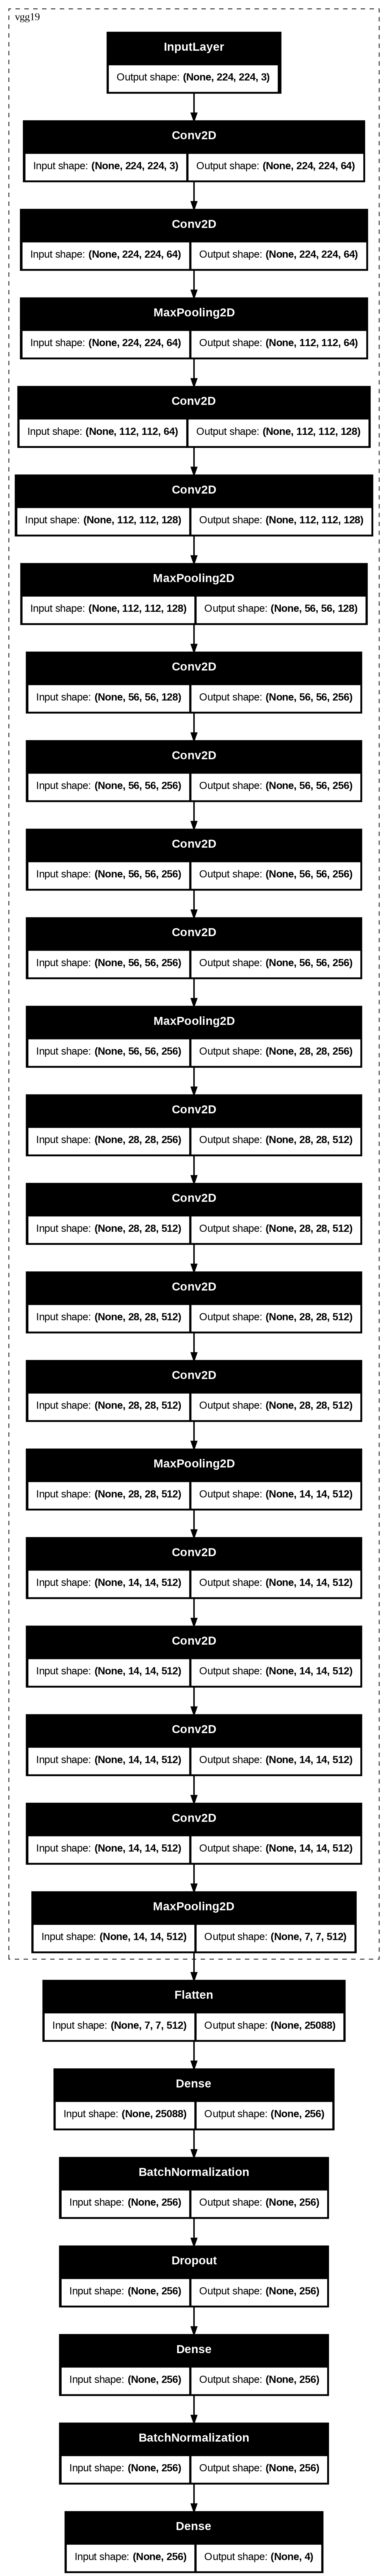

In [32]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                # can set 5-10 depending on curve
    restore_best_weights=True, # revert to best model
    verbose=2
)

model_checkpoint = ModelCheckpoint(
    'best_vgg19.keras',
    monitor='val_loss',
    save_best_only=True,
    # verbose=1
)


In [34]:
his = model.fit(
    train_data,       # Training data
    validation_data=valid_data,  # Validation data
    epochs=20,        # Number of training epochs
    verbose=1,        # Verbosity detail level for training logs
    callbacks=[early_stop, model_checkpoint]  # Callback functions
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 110s 427ms/step - accuracy: 0.6135 - auc: 0.8466 - loss: 1.0099 - precision: 0.6448 - recall: 0.5645 - val_accuracy: 0.8038 - val_auc: 0.9537 - val_loss: 0.5305 - val_precision: 0.8220 - val_recall: 0.7816
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 90s 402ms/step - accuracy: 0.7694 - auc: 0.9394 - loss: 0.5975 - precision: 0.7940 - recall: 0.7443 - val_accuracy: 0.8180 - val_auc: 0.9665 - val_loss: 0.4412 - val_precision: 0.8413 - val_recall: 0.8054
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 85s 380ms/step - accuracy: 0.8240 - auc: 0.9617 - loss: 0.4668 - precision: 0.8400 - recall: 0.7989 - val_accuracy: 0.8655 - val_auc: 0.9720 - val_loss: 0.3927 - val_precision: 0.8750 - val_recall: 0.8528
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 84s 373ms/step - accuracy: 0.8278 - auc: 0.9663 - loss: 0.4373 - precision: 0.8450 - recall: 0.8066 - val_accuracy: 0.8497 - val_auc: 0.9740 - val_loss: 0.3828 - val_precision: 0.8613 - val_recall: 0.8354
Epoch 5/20
225/225 

In [35]:
loss, accuracy, precision, recall, auc = model.evaluate(valid_data)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step - accuracy: 0.9161 - auc: 0.9865 - loss: 0.2637 - precision: 0.9223 - recall: 0.9017
Loss: 0.31444358825683594
Accuracy: 0.9034810066223145
Precision: 0.9079160094261169
Recall: 0.8892405033111572
AUC: 0.9807355999946594


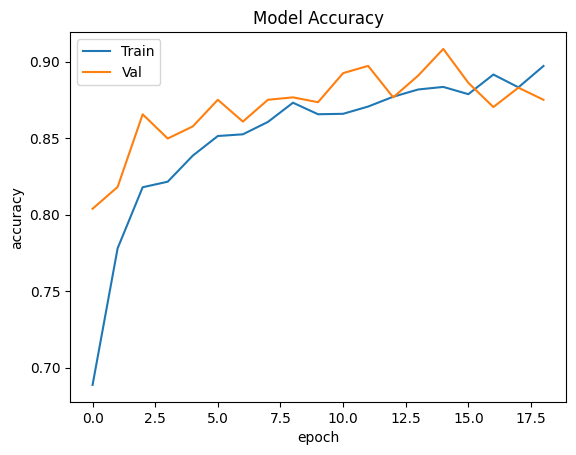

In [36]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

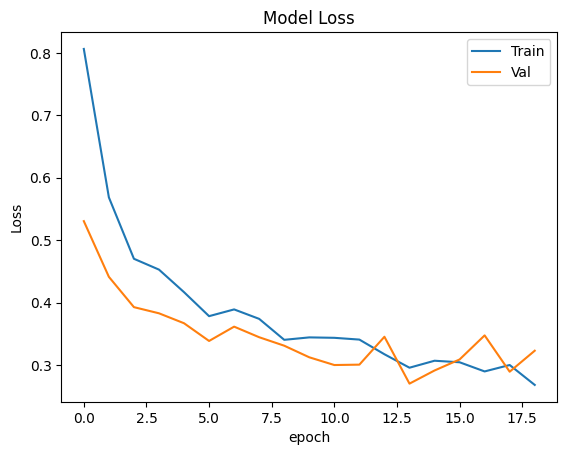

In [37]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [38]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()

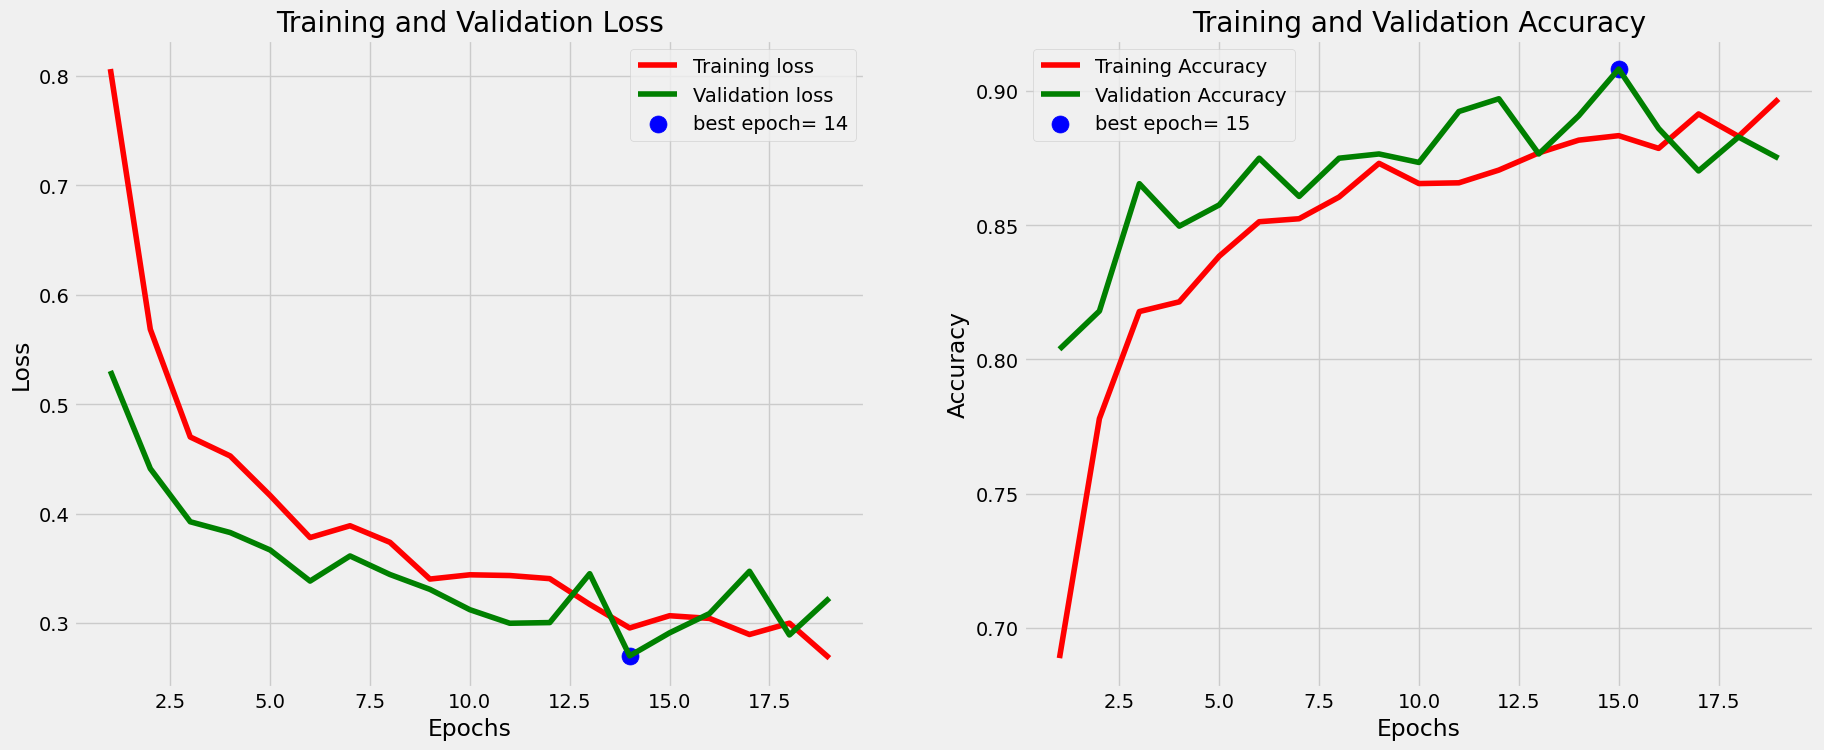

<Figure size 640x480 with 0 Axes>

In [39]:
# plot the history
tr_plot(his,0)
plt.savefig('history.png')

## Model Evaluation

In [40]:
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step


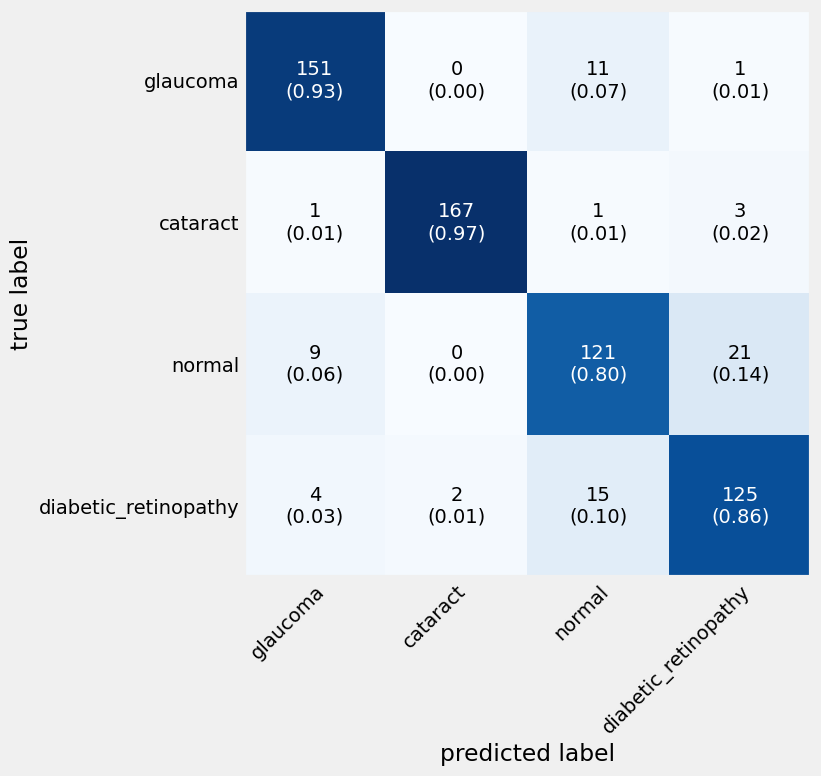

In [41]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"],
                      show_normed = True);
plt.savefig("Predected & True Label")

In [42]:
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.92      0.93      0.92       163
diabetic_retinopathy       0.99      0.97      0.98       172
            glaucoma       0.82      0.80      0.81       151
              normal       0.83      0.86      0.84       146

            accuracy                           0.89       632
           macro avg       0.89      0.89      0.89       632
        weighted avg       0.89      0.89      0.89       632



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


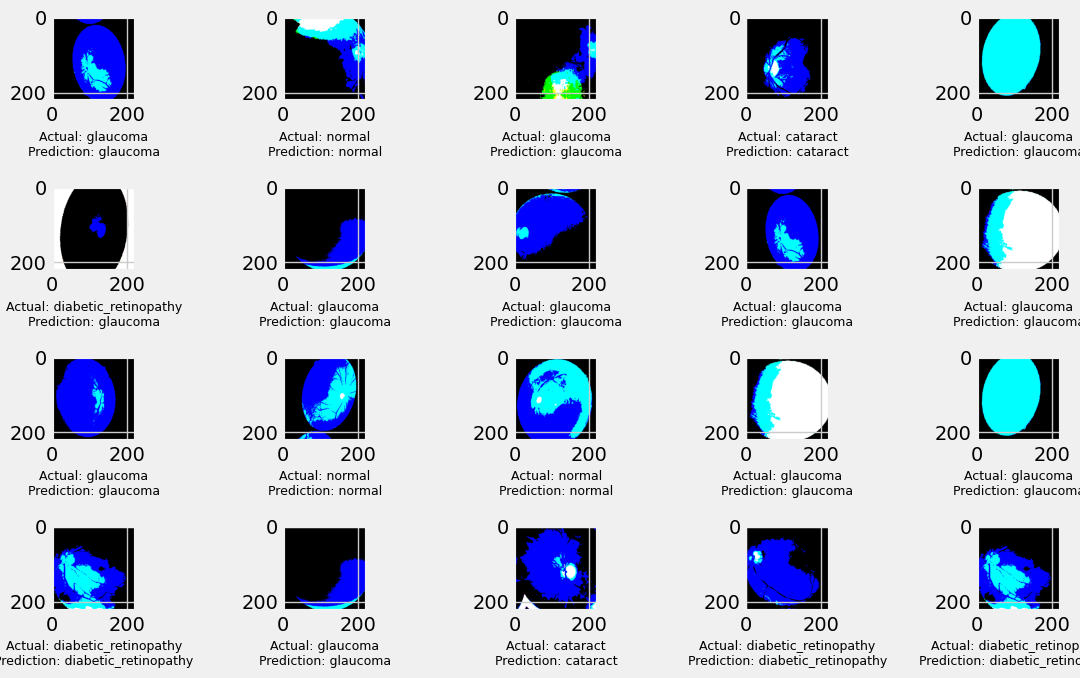

In [43]:
import random
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"]

# Get a batch of data from the valid_data generator
images, labels = next(valid_data)

# Replace these variables with your actual data
y_pred = model.predict(images)  # Assuming you have a trained model

plt.figure(figsize=(12, 7))

for i in range(20):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]
    category_index = labels[sample_index].argmax()
    pred_category_index = y_pred[sample_index].argmax()

    label = class_labels[category_index]
    pred_label = class_labels[pred_category_index]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)

    # Change the font size for labels
    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label), fontsize=9)  # Change the fontsize as needed

plt.tight_layout()

# Save the plot as an image
plt.savefig('Model Eval.png')

plt.show()

# Save Model

In [44]:
model.save("best_vgg19.keras")